In [1]:
import scipy
print(scipy.__version__)
if scipy.__version__ != "1.1.0":
  !pip install scipy==1.1.0

1.1.0


In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, model_from_json, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from keras.utils import to_categorical
import os, numpy as np
from skimage.transform import resize

from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from PIL import Image 
import cv2

import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix

from vis.utils import utils
from vis.visualization import visualize_cam
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [0]:
X_test = np.load("drive/My Drive/CV/testx.npy")
Y_test = np.load("drive/My Drive/CV/testy.npy")

In [0]:
bins = {}

for i in range(Y.shape[0]):
    if Y[i] not in bins:
        bins[Y[i]] = []
    bins[Y[i]].append(X[i])
    
for b in bins:
    bins[b] = np.array(bins[b])
    
del X
del Y

In [0]:
augment_image = {}

def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    image = rotate(image, angle)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image

augment_image[0] = anticlockwise_rotation

def clockwise_rotation(image):
    angle= random.randint(0,180)
    image = rotate(image, -angle)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image

augment_image[1] = clockwise_rotation

def h_flip(image):
    return  np.fliplr(image)

augment_image[2] = h_flip

def v_flip(image):
    return np.flipud(image)

augment_image[3] = v_flip

def add_noise(image):
    image = random_noise(image)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image 

augment_image[4] = add_noise

def blur_image(image):
    image = gaussian(image, sigma = random.uniform(0, 1), multichannel=True)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image

augment_image[5] = blur_image

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [0]:
def augment_covid(data, no=1200):
    n = data.shape[0]
    i = 0
    new_data = list(data)
    while len(new_data) < no:
        times_to_augment = random.randint(1, 3)
        img = data[i]
        for j in range(times_to_augment):
            r = random.randint(0, 5)
            img = augment_image[r](img)
        print(i)        
        new_data.append(img)
        i += 1
        i %= n
    
    return new_data

In [13]:
for b in bins:
    bins[b] = augment_covid(bins[b])
    bins[b] = np.array(bins[b])
    np.random.shuffle(bins[b])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: ignored

In [0]:
training_no = {}
training_samples = 200
for b in bins:
    training_no[b] = len(bins[b]) - training_samples

In [0]:
X_train = []
Y_train = []
X_test = []
Y_test = []
for b in bins:
    X_train = X_train + list(bins[b][:training_no[b]])
    X_test = X_test + list(bins[b][training_no[b]:])
    Y_train = Y_train + [b]*training_no[b]
    Y_test = Y_test + [b]*training_samples

In [11]:
input_shape = (128, 128)
print(Y_test.shape)
# Y_train = to_categorical(np.array(Y_train, dtype='int32'), 3)
Y_test = to_categorical(np.array(Y_test, dtype='int32'), 3)
print(Y_test.shape)

(587,)
(587, 3)


In [12]:
# for i in range(len(X_train)):
#     if not (i%100):
#         print(i)
#     X_train[i] = resize(X_train[i], input_shape)
#     X_train[i] = cv2.normalize(X_train[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
X_t_t = []
for i in range(len(X_test)):
    if not (i%100):
        print(i)
    t = resize(X_test[i], input_shape)
    t = cv2.normalize(t, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    X_t_t.append(t)

0
100
200
300
400
500


In [0]:
# X_train = np.array(X_train)
X_test = np.array(X_t_t)

In [0]:
def save_model(model, name):
    # serialize model to JSON
    model_json = model.to_json()
    with open("model_" + name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model_" + name + ".h5")
    print("Saved " + name + " to disk")

In [0]:
def load_model(json_file_name, weights_file_name):
    json_file = open(json_file_name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weights_file_name)
    print("Loaded model from disk")
    return loaded_model

In [0]:
def get_params(model, X, Y):
    scores = model.evaluate(X, Y, verbose=0)
    for i in range(len(scores)):
        print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))
    
    m = (2 * scores[1] * scores[2]) / (scores[1] + scores[2])
    print("%s: %.2f%%" % ("F1 Score", m*100))
    Y_P = model.predict(X)
    matrix = confusion_matrix(Y.argmax(axis=1), Y_P.argmax(axis=1))
    print("Confusion Matrix is:")
    print(matrix)

In [17]:
loaded_model = load_model("drive/My Drive/CV/model_final_resnet_20_200.json", "drive/My Drive/CV/model_final_resnet_20_200.h5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
loaded_model.summary()

Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_____________________________________________________________________

In [18]:
print(Y_test[0], X_test.shape)

[1. 0. 0.] (587, 128, 128, 3)


In [19]:
get_params(loaded_model, X_test, Y_test)

loss: 26.03%
accuracy: 95.74%
precision_1: 95.74%
recall_1: 95.74%
F1 Score: 95.74%
Confusion Matrix is:
[[ 46   0   3]
 [  2 259   8]
 [  1  11 257]]


In [0]:
loaded_model = load_model("drive/My Drive/CV/model_final_resnet_20_200.json", "drive/My Drive/CV/model_final_resnet_20_200.h5")
loaded_model.summary()

Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_____________________________________________________________________

In [0]:
model = loaded_model
layer_idx = utils.find_layer_idx(model, "dense_2")
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

ValueError: ignored

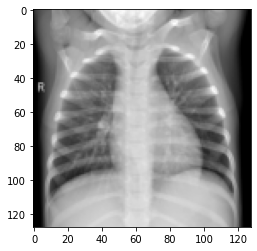

In [23]:
index = random.randint(0,len(X_test)-1)
img = X_test[index]
plt.imshow(img)

In [0]:
y_pred = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
print("Predicted label of the image is " + str(np.argmax(y_pred,axis=1)[0]))

Predicted label of the image is 2


In [0]:
penultimate_layer_idx = utils.find_layer_idx(model, "conv2d_21") 
class_idx  = class_idxs_sorted[0]
seed_input = img
grad_plot = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

Class is 2
482


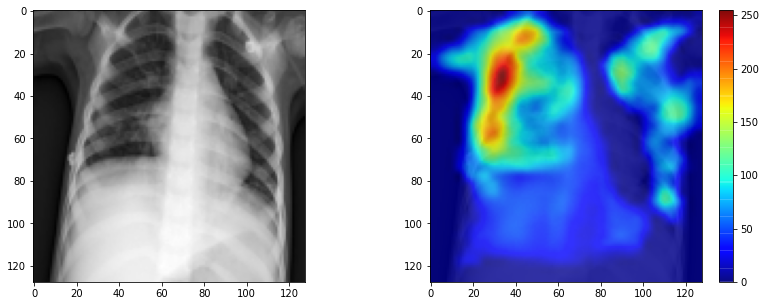

In [0]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img)
    axes[1].imshow(img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
plot_map(grad_plot)
cl = str(np.argmax(y_pred,axis=1)[0])
print("Class is " + str(cl)) 
print(index)

In [0]:
loaded_model = load_model("drive/My Drive/CV/model_final_resnet_20_200.json", "drive/My Drive/CV/model_final_resnet_20_200.h5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
loaded_model.summary()

Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_____________________________________________________________________

In [0]:
model = loaded_model
y_score = model.predict(X_test)
y_test = Y_test
n_classes = 3

{0: array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, 9.9999964e-01,
       9.9999952e-01, 9.9999940e-01, 9.9999928e-01, 9.9999917e-01,
       9.9999869e-01, 9.9999833e-01, 9.9999821e-01, 9.9999785e-01,
       9.9999726e-01, 9.9999714e-01, 9.9999440e-01, 9.9999416e-01,
       9.9999261e-01, 9.9999225e-01, 9.9998653e-01, 9.9998617e-01,
       9.9986374e-01, 9.9985051e-01, 9.9983883e-01, 9.9963534e-01,
       9.9961531e-01, 9.9924529e-01, 9.9924457e-01, 9.7975838e-01,
       9.7392488e-01, 9.5396137e-01, 9.4484013e-01, 8.5644579e-01,
       7.9818422e-01, 5.3945470e-01, 5.3818834e-01, 5.1895010e-01,
       3.4769979e-01, 2.8281167e-01, 9.3282870e-04, 8.2991127e-04,
       4.7079989e-15], dtype=float32), 1: array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, 9.9999976e-01,
       9.9999964e-01, 9.9999952e-01, 9.9999940e-01, 9.9999905e-01,
       9.9999893e-01, 9.9999881e-01, 9.9999857e-01, 9.9999845e-01,
       9.9999774e-01, 9.9999762e-01, 9.9999678e-01, 9.9999630e-01,
       9.9997270

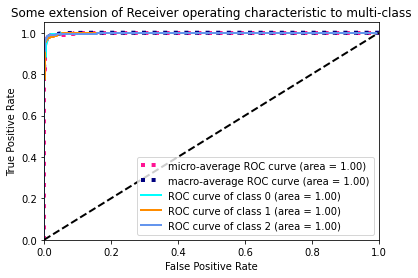

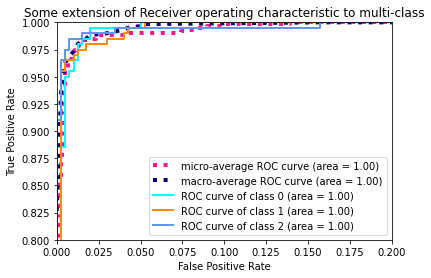

In [0]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thr[i] = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(thr, roc_auc)
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()